In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
outputdir = Path('Analyse_klimaat')

In [3]:
def maas_afvoer_verdrag(Q, l_in = 'ongedeelde Maasafvoer Monsin (Kanne + St. Pieter)', l_uit = 'Maas (St. Pieter)'):

    MAV = pd.read_excel(r'Afvoeren/Afvoerverdeling_Maas.xlsx', sheet_name='Afvoerverdeling', header=1, skiprows=[2])
    MAV = MAV.sort_index(ascending=False)

    Q_uit = np.interp(Q, MAV[l_in], MAV[l_uit])

    # Corrigeer de extrapolatie. 
    # Boven het maximum, wordt verondersteld dat l_uit gelijk is aan l_in minus het verschil op de laatste regel van de MAV-tabel
    ii = Q > MAV[l_in].max()
    Q_uit[ii] = Q[ii] - (MAV[l_in].max() - MAV[l_uit].max())
    
    # Onder het minimum wordt dezelfde verhouding doorgezet
    ii = Q < MAV[l_in].min()
    Q_uit[ii] = Q[ii] * (MAV[l_uit].min() / MAV[l_in].min())
    
    if hasattr(Q, 'index'):
        Q_uit = pd.Series(index=Q.index, data=Q_uit)
    
    return Q_uit  

In [351]:
# Read karakteristieke jaren
Q_SP = {} 
for s in ['T100', 'T10', 'T2', 'T1']:
    Q_SP[s] = pd.read_excel(f'Afvoeren/CDF_karakteristieke_jaren_{s}.xlsx', index_col=0)
Q_SP['Gemiddelde'] = pd.read_excel('Afvoeren/Non_exceedance.xlsx', index_col=0)
Q_SP = pd.concat(Q_SP, axis=1).swaplevel(axis=1).sort_index(axis=1)
Q_SP = Q_SP.reindex(['T100', 'T10', 'T2', 'T1'] + ['Gemiddelde'], axis=1, level=1)
Q_SP = Q_SP * 365

In [352]:
# Read individual years
Q_SP_allejaren = pd.read_excel(f'Afvoeren/Non_exceedance_yearly.xlsx', index_col=[0, 1])
Q_SP_allejaren = Q_SP_allejaren.unstack(level=1).swaplevel(axis=1).sort_index(axis=1)

In [353]:
# Toepassen Maas afvoer verdrag
Q_JK = maas_afvoer_verdrag(Q_SP.index, l_in = 'Maas (St. Pieter)', l_uit='Julianakanaal (Bunde)')
Q_Grensmaas = maas_afvoer_verdrag(Q_SP.index, l_in = 'Maas (St. Pieter)', l_uit='Gemeen-schappelijke Maas (Borgharen)')

In [354]:
onttrekkingen_B = 1.6  # DSM 
onttrekkingen_C = 0

lekdebiet_Born = 1
lekdebiet_Maasbracht = 1
lekdebiet_Heel = 1

Q_Panheel = 0
Q_stuwlinne = 5
Q_sluislinne = 1
Q_overig_Linne = 1

Q_Born = Q_JK - onttrekkingen_B - lekdebiet_Born
Q_Maasbracht = Q_Born + lekdebiet_Born - onttrekkingen_C - lekdebiet_Maasbracht
Q_Heel = Q_Grensmaas + Q_Maasbracht + lekdebiet_Maasbracht + Q_Panheel - Q_stuwlinne - Q_sluislinne - Q_overig_Linne - lekdebiet_Heel

Q_Born = np.maximum(Q_Born, 0)
Q_Maasbracht = np.maximum(Q_Maasbracht, 0)
Q_Heel = np.maximum(Q_Heel, 0)

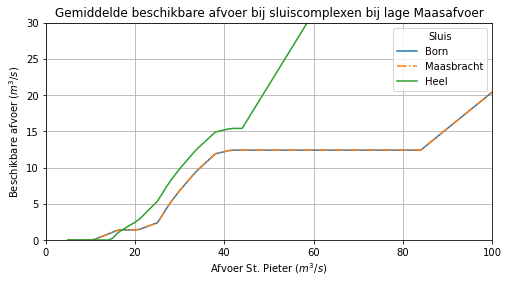

In [355]:
plt.subplots(figsize=(8,4))
plt.plot(Q_SP.index, Q_Born, label='Born')
plt.plot(Q_SP.index, Q_Maasbracht, label='Maasbracht', ls='-.')
plt.plot(Q_SP.index, Q_Heel, label='Heel', ls='-')


plt.xlim(0, 100)
plt.ylim(0, 30)
plt.xlabel('Afvoer St. Pieter ($m^3/s$)')
plt.ylabel('Beschikbare afvoer ($m^3/s$)')
plt.title('Gemiddelde beschikbare afvoer bij sluiscomplexen bij lage Maasafvoer')
plt.grid()
plt.legend(title='Sluis')

plt.savefig(outputdir / 'Beschikbare_afvoer_sluiscomplexen.png', dpi=150, bbox_inches='tight')
plt.savefig(outputdir / 'Beschikbare_afvoer_sluiscomplexen.svg', bbox_inches='tight')

In [356]:
lock = 'Maasbracht'
scenarios = pd.read_csv(f'Ontwerp laagwaterbeleid/{lock}_Laagwaterbeleid.csv', index_col=0)
scenarios = scenarios.sort_index()  # Sorting is necessary for the interp

In [357]:
onderschrijding_Maasbracht = Q_SP
onderschrijding_Maasbracht.index = Q_Maasbracht

In [358]:
onderschrijding_Maasbracht_WH2050 = Q_SP_WH2050
onderschrijding_Maasbracht_WH2050.index = Q_Maasbracht

In [359]:

def addSecond_x_axes(ax1_ticks, ax2_ticks_labels, ax2_color='#888', ax2_label=None, ax1=None, position=40):
    '''
    Add a second xlabel below the current
    
    ax1_ticks: Locations on current xaxis where markers should be placed
    ax2_ticks_labels: Labels to put at these positions
    
    ax2_color: Color of all ax2 objects
    ax2_label: xlabel
    ax1: axes to apply function on. By default uses current axes
    
    return: ax2 handle
    '''
    
    if not ax1:
        ax1=plt.gca()
        
    assert all(ax1_ticks >= ax1.get_xlim()[0]) and all(ax1_ticks <= ax1.get_xlim()[1]), 'ax1_ticks larger than xlim. Ticks: {ticks}; Limits: {limits}'.format(ticks=ax1_ticks, limits=ax1.get_xlim())
   
    ax2 = ax1.twiny()

    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom') 
    ax2.spines['bottom'].set_position(('outward', position))
    ax2.spines['bottom'].set_color(ax2_color)
    ax2.tick_params(axis='x', colors=ax2_color)

    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xticks(ax1_ticks, )
    ax2.set_xticklabels(ax2_ticks_labels)
    ax2.set_xlabel(ax2_label, color=ax2_color)
    return ax2


In [360]:
def interpolate_dataframe(df, new_index):
    # Reindex with both old and new index, interpolate to new index, and only keep new index
    f = df. \
        reindex(df.index.union(new_index)). \
        interpolate(method='index'). \
        drop_duplicates(). \
        reindex(new_index, method='ffill')  # Fill the duplicates again that were previously removed
    return f

In [361]:
def bereken_schadeperjaar(onderschrijding_Maasbracht, scenarios):
    """
    
    returns: geinterpoleerde scenarios en totale schade per jaar
    """
    
    afvoeren = onderschrijding_Maasbracht.index
    scenarios_interp = interpolate_dataframe(scenarios, afvoeren)
    
    schadeperjaar = pd.concat({
        'Kosten scheepvaart (mln eur)': onderschrijding_Maasbracht.diff().multiply(scenarios_interp['Totale toename kosten scheepvaart (eur) per dag'], axis=0).sum(),
        'Pompkosten (mln eur)': onderschrijding_Maasbracht.diff().multiply(scenarios_interp['Pompkosten (eur) per dag'], axis=0).sum()
    }, axis=1) / 1e6
    return scenarios_interp, schadeperjaar

In [373]:
scenarios_interp, schadeperjaar = bereken_schadeperjaar(onderschrijding_Maasbracht, scenarios)

In [363]:
scenario = 'Ref'

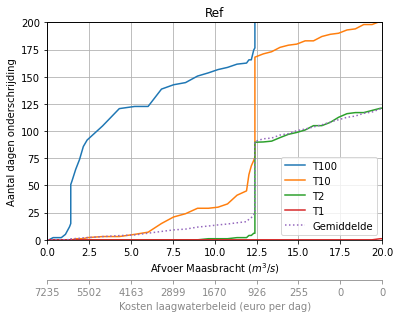

In [401]:
onderschrijding_Maasbracht[scenario].iloc[:,:-1].plot()
onderschrijding_Maasbracht[scenario].iloc[:,-1].plot(ls=':')
plt.legend()
plt.xlim(0, 20)
plt.ylim(0., 200)
plt.grid()
plt.ylabel('Aantal dagen onderschrijding')
plt.xlabel('Afvoer Maasbracht ($m^3/s$)')
plt.title(scenario)

afvoer_xas = plt.gca().get_xticks()
kosten_xas = scenarios_interp.drop_duplicates()['Totale kosten (eur) per dag'].reindex(afvoer_xas, method='ffill')
kosten_xas_labels = [f'{s:.0f}' for s in kosten_xas]

addSecond_x_axes(afvoer_xas, kosten_xas_labels, ax2_label='Kosten laagwaterbeleid (euro per dag)')


plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid.png', dpi=150, bbox_inches='tight')
plt.savefig(outputdir / f'{lock}_Onderschrijdingskromme_laagwaterbeleid.svg', bbox_inches='tight')

In [ ]:
plt.axvspan

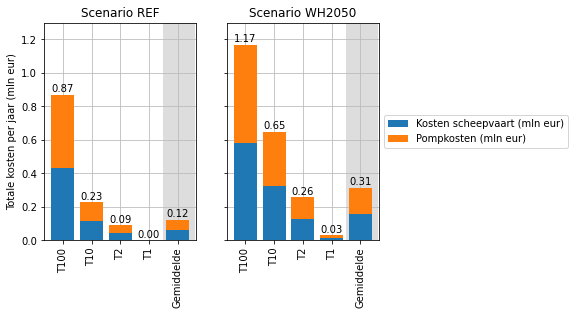

In [400]:
f, ax = plt.subplots(ncols=2, figsize=(6,4), sharey=True)

plt.sca(ax[0])
schadeperjaar.loc['Ref'].plot.bar(width=0.8, zorder=3, stacked=True, ax=ax[0], legend=False)
plt.grid(c='#BBB')
plt.ylabel('Totale kosten per jaar (mln eur)')
plt.title('Scenario REF')
plt.axvspan(3.5, 4.6, facecolor='#DDD', zorder=-5)
for i, v in enumerate(schadeperjaar.loc['Ref'].sum(axis=1).values):
#     if v < 0.01: continue
    plt.annotate(text=f'{v:.2f}', xy=(i, v), ha='center', xytext=(0, 3), textcoords='offset points')

plt.sca(ax[1])
schadeperjaar.loc['WH_2050'].plot.bar(width=0.8, zorder=3, stacked=True, ax=ax[1])
plt.grid(c='#BBB')
plt.axvspan(3.5, 4.6, facecolor='#DDD', zorder=-5)
plt.ylabel('Totale kosten per jaar (mln eur)')
plt.title('Scenario WH2050')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))


for i, v in enumerate(schadeperjaar.loc['WH_2050'].sum(axis=1).values):
    plt.annotate(text=f'{v:.2f}', xy=(i, v), ha='center', xytext=(0, 3), textcoords='offset points')
    
plt.ylim(top=1.3)


plt.savefig(outputdir / f'{lock}_Kosten_per_jaar.png', dpi=150, bbox_inches='tight')
plt.savefig(outputdir / f'{lock}_Kosten_per_jaar.svg', bbox_inches='tight')